# Carvana Image Masking Challenge

https://www.kaggle.com/c/carvana-image-masking-challenge

In [1]:
%matplotlib inline
import cv2
import imageio
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

print(cv2.__version__)
print(imageio.__version__)
print(tf.__version__)

4.5.4-dev
2.9.0
2.7.0


## Загружаем исходные изображения

In [2]:
from glob import glob

IMG_HEIGHT = 320
IMG_WIDTH = 480

train_img_paths = sorted(glob('data/carvana/train/*.jpg'))
train_mask_paths = sorted(glob('data/carvana/train_masks/*.gif'))

def load_image(path):
    # используем imageio, тк cv2 
    # не поддерживает загрузку .gif
    img = imageio.imread(path)
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

def binarise(img):
    thr, result = cv2.threshold(img, -1, 1, cv2.THRESH_OTSU)
    return result

train_imgs = np.array(
    [load_image(path) for path in train_img_paths])

train_masks = np.array(
    [binarise(load_image(path)) for path in train_mask_paths])

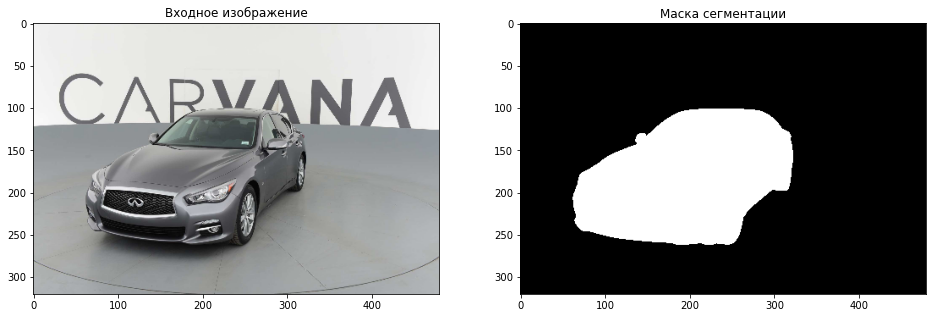

In [3]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Входное изображение')
plt.imshow(train_imgs[1]);

plt.subplot(1, 2, 2)
plt.title('Маска сегментации')
plt.imshow(train_masks[1], cmap='gray');

## Инициализируем архитектуру U-Net

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate

def create_unet(height, width):
    inputs = Input((height, width, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5),
                       conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6),
                       conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return tf.keras.Model(inputs=[inputs], outputs=[conv10])

In [5]:
model = create_unet(IMG_HEIGHT, IMG_WIDTH)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 480, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 320, 480, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

## Задаем функцию потерь

In [6]:
SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_pred_f = tf.reshape(y_pred, [-1])
    y_true_f = tf.reshape(y_true, [-1])
    y_true_f = tf.cast(y_true_f, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (tf.reduce_sum(y_true_f + y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.2 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

## Запускаем процесс обучения

In [7]:
model.compile(tf.keras.optimizers.Adam(lr=1e-4),
              bce_dice_loss,
              metrics=[tf.keras.losses.binary_crossentropy, dice_coef])

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
model.fit(train_imgs, train_masks, batch_size=4, epochs=1)

8/8 [==============================] - 30s 4s/step - loss: -0.3406 - binary_crossentropy: 0.6599 - dice_coef: 0.4726


## Предсказание модели

In [10]:
test_paths = sorted(glob('data/carvana/test/*.jpg'))

def test_img_generator(test_paths):
    for path in test_paths:
        yield np.array([load_image(path)])

In [11]:
test_iter = test_img_generator(test_paths)
pred = model.predict(test_iter)

## Визуализируем результат на тестовом семпле

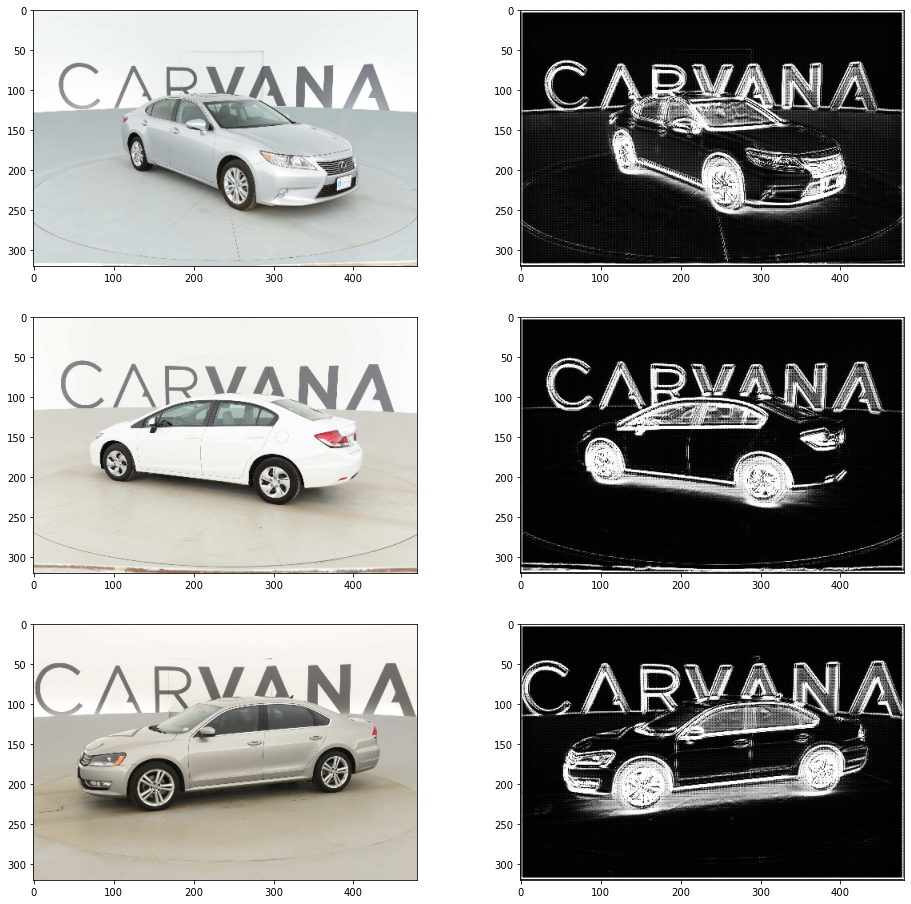

In [12]:
SHOW_SAMPLES = min(len(pred), 3)

fig = plt.figure(0, figsize=(16, 16))

for i in range(SHOW_SAMPLES):
    plt.subplot(SHOW_SAMPLES, 2, 2*i+1)
    plt.imshow(load_image(test_paths[i]))
    plt.subplot(SHOW_SAMPLES, 2, 2*i+2)
    plt.imshow(pred[i], cmap='gray')